In [102]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime

import umap, umap.plot
import io

import fastprogress
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tf.get_logger().setLevel('ERROR')


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from bayes_vi.utils.leapfrog_integrator import LeapfrogIntegrator
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

In [4]:
mapper = umap.UMAP().fit(tf.reshape(x_train/255., (x_train.shape[0], -1)))

<AxesSubplot:>

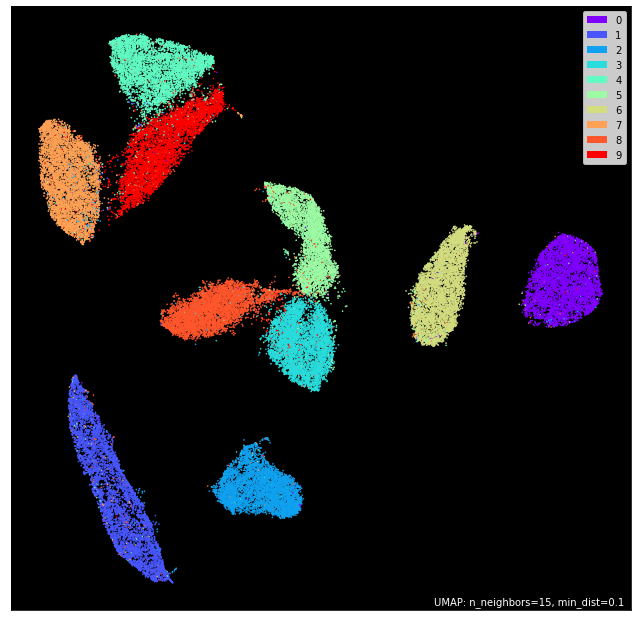

In [5]:
umap.plot.points(mapper, labels=tf.reshape(y_train, (-1,)).numpy(), theme='fire')

In [147]:
x_train = tf.random.shuffle(tf.cast(x_train, tf.float32)) / 255.
x_shape = x_train[0].shape
flat_x_train = tf.reshape(x_train, (x_train.shape[0], -1))
flat_x_shape = flat_x_train[0].shape
dims = flat_x_shape[0]

dataset = tf.data.Dataset.from_tensor_slices(flat_x_train)

In [148]:
base_dist = tfd.MultivariateNormalDiag(
    loc=tf.zeros(dims), scale_diag=tf.ones(dims)
)

loc_fn = make_shift_fn(dims, hidden_layers=[128,128])
scale_fn = make_scale_fn(dims, hidden_layers=[128,128])

encoder = lambda q: tfd.MultivariateNormalDiag(loc=loc_fn(q), scale_diag=scale_fn(q))

In [149]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)

def get_masked_autoregressive_flow_bijector(unconstrained_event_dims):
    return tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, hidden_units=[32, 32], activation='relu')
    )


In [150]:
cnf = tfd.TransformedDistribution(
    base_dist,
    bijector=get_masked_autoregressive_flow_bijector(dims)
)

num_flows = 2
hnf = tfd.TransformedDistribution(
    base_dist, 
    bijector=tfb.Chain([
        tfb.Split(2, axis=-1),
        *[HamiltonianFlow(
            event_dims=dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=tf.Variable(0.1), 
            num_integration_steps=2,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)]
    ])
)

In [151]:
epochs = 25
batch_size = 64
#sample_size = 10

num_test_images = 5

optimizer = tf.optimizers.Adam(learning_rate=1e-3)

In [152]:
@tf.function(autograph=False)
def optimizer_step(q):
    
    with tf.GradientTape() as tape:
        #cond_dist = encoder(q)
        #p = cond_dist.sample(sample_size)
        loss = -tf.reduce_mean(cnf.log_prob(q)) #- tf.reduce_mean(hnf.log_prob([tf.stack([q]*sample_size, axis=0),p]) - cond_dist.log_prob(p))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

@tf.function(autograph=False)
def generate_test_images(num_images, flow):
    q = flow.sample(num_images)
    shifted = q + tf.abs(tf.reduce_min(q))
    scaled = shifted / tf.reduce_max(shifted)
    return tf.reshape(scaled, (-1, *x_shape))

def generate_umap_plot(flow):
    images = generate_test_images(1000, flow)
    shifted = images + tf.abs(tf.reduce_min(images))
    scaled = shifted / tf.reduce_max(shifted)
    reshaped = tf.reshape(scaled, (scaled.shape[0], -1)).numpy()
    #mapper = umap.UMAP().fit(reshaped)
    return umap.plot.points(mapper, values=tf.reduce_sum(reshaped, axis=1).numpy(), theme='fire')

In [153]:
!rm -rf ./logs/

In [154]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [155]:
%tensorboard --logdir logs


In [156]:
epochs = fastprogress.master_bar(range(epochs))

In [157]:
step = 0 

for _ in epochs:

    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=epochs)
    
    for q in batches:
        step += 1 
        loss = optimizer_step(q)

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss, step=step)
        
        if step % 500 == 0:
            images = generate_test_images(num_test_images, hnf)
            with train_summary_writer.as_default():
                tf.summary.image('Generated Images - Step {}'.format(step), tf.expand_dims(images, axis=-1), max_outputs=num_test_images, step=step)



IndexError: index 10 is out of bounds for axis 0 with size 10

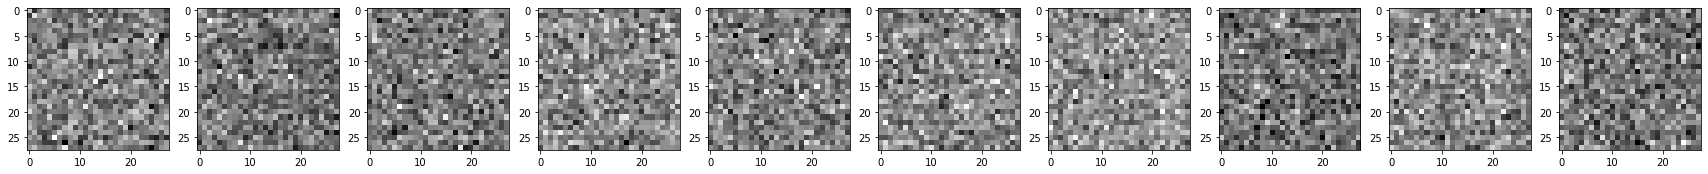

In [158]:
fig, axes = plt.subplots(1,10, figsize=(30,3))

for i, img in enumerate(generate_test_images(10, hnf)):
    axes[i].imshow(img, cmap='gray')

In [ ]:
generate_umap_plot(flow)